In [296]:
def initialize_qubits(given_circuit, n, m):
    given_circuit.h(range(n))
    given_circuit.x(n+m-1)
    

In [297]:
from qiskit import QuantumCircuit

def a_x_mod15(a, x):
    if a not in [2,7,8,11,13]:
        raise ValueError("'a' must be 2,7,8,11 or 13")
    U = QuantumCircuit(4)
    for iteration in range(x):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a == 11:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, x)
    c_U = U.control()
    return c_U

# a_x_mod15(8, 2).definition.draw("mpl", style={'name': 'bw'}, scale=0.5, fold=150)

In [298]:
def modular_exponentiation(given_circuit, n, m, a):
    for x in range(n):
        exponent = 2**x
        given_circuit.append(a_x_mod15(a, exponent), 
                     [x] + list(range(n, n+m)))
            

In [299]:
from qiskit.circuit.library import QFT

In [300]:
def apply_qft(given_circuit, measurement_qubits):
    given_circuit.append(QFT( len(measurement_qubits), do_swaps=False), measurement_qubits)
    

In [301]:
from qiskit import QuantumCircuit

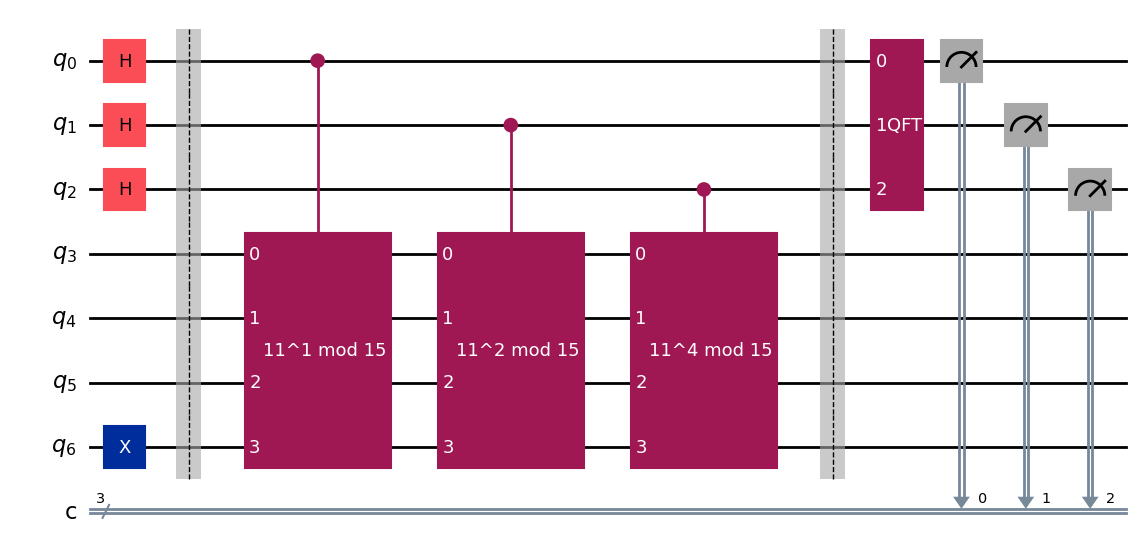

In [302]:
def shor_program(n, m, a):
    
    # set up quantum circuit
    shor = QuantumCircuit(n+m, n)
    
    # initialize the qubits
    initialize_qubits(shor, n, m)
    shor.barrier()

    # apply modular exponentiation
    modular_exponentiation(shor, n, m, a)
    shor.barrier()

    # apply inverse QFT
    apply_qft(shor, range(n))

    # measure the first n qubits
    shor.measure(range(n), range(n))
    
    return shor
    
n = 3; m = 4; a = 11

mycircuit = shor_program(n, m, a)
mycircuit.draw("mpl")

/var/folders/hq/4hntmyx54f34qfdbn8_j36l00000gn/T/ipykernel_93567/2984660200.py:10: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime.
  job = backend.run(transpiled_circuit, shots=2000)


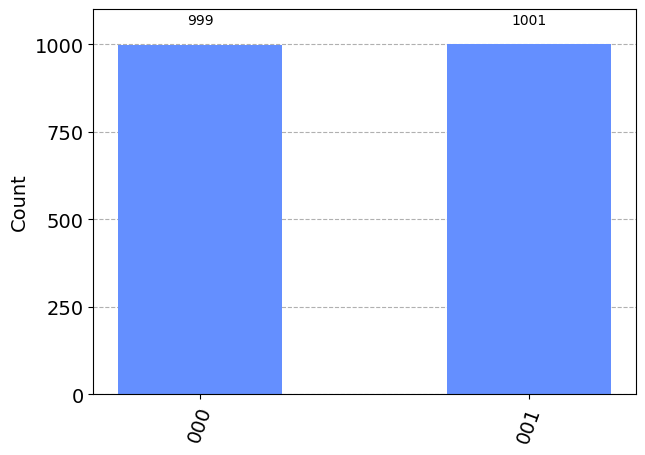

In [303]:
from qiskit import transpile
from qiskit_ibm_runtime.fake_provider import FakeCairoV2
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
backend = service.get_backend("ibmq_qasm_simulator")

transpiled_circuit = transpile(mycircuit, backend)
job = backend.run(transpiled_circuit, shots=2000)
result = job.result()
counts = result.get_counts(transpiled_circuit)


plot_histogram(counts)

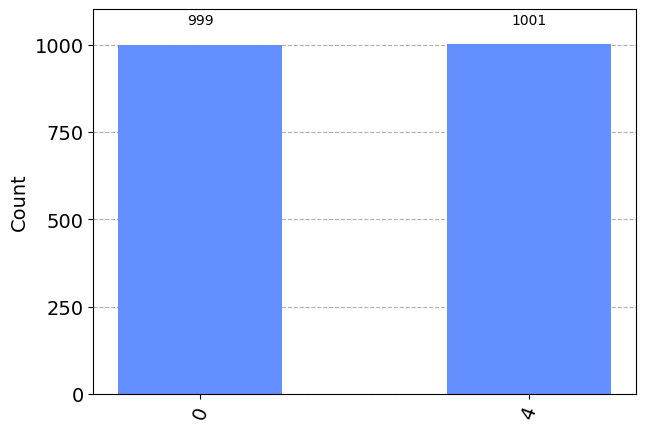

In [304]:
threshold = 0.01 * 2000 

complete_counts = { format(i, '0%sb' % n): counts.get(format(i, '0%sb' % n), 0) for i in range(2**n) }
complete_counts = {int(key[::-1], 2): val for key, val in complete_counts.items() if val > threshold}
plot_histogram(complete_counts)

In [305]:
from math import gcd

ans = gcd(*complete_counts) # ans should be T (= 2^n) / r

r = (2 ** n) / ans

print(f"Computed r = {r}")

if r % 2 != 0:
    print("Failed. Measured value is not an even number")
x = int((a ** (r/2)) % 15)
if (x + 1) % 15 == 0:
    print("Failed. x + 1 = 0 (mod N) where x = a^(r/2) (mod N)")

g = gcd(x + 1, 15)
guesses = g, gcd(x - 1, 15)
print(guesses)


if g != 0 and 15 % g == 0 and g != 15 and g != 1:
    print(f"Found {g}")

Computed r = 2.0
(3, 5)
Found 3
